# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import justext
import os
from transformers import GPT2Tokenizer
import json
import re

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

/home/lamprecht/code/ibm_recommendation_engine/ibm_rec_env_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Print some general statistics about the data

# Number of (unique) users
n_usr = df["email"].dropna(axis="rows").unique().shape[0]

# Number of articles in `df`
num_art_df = df["article_id"].unique().shape[0]

# Number of articles in `df_content`
num_art_dfcnt = df_content["article_id"].unique().shape[0]

print(f"There are {n_usr} unique users in our dataset.")
print(f"There exist {num_art_df} unique articles in the `df` dataframe.")
print(f"There exist {num_art_dfcnt} unique articles in the `df_content` dataframe.")

There are 5148 unique users in our dataset.
There exist 714 unique articles in the `df` dataframe.
There exist 1051 unique articles in the `df_content` dataframe.


In [4]:
# Get number of interactions for each user (identified by hashed email)
# using `value_counts`
usr_interacts = df["email"].value_counts()

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(usr_interacts.values)
print(f"50% of individuals interact with {median_val} number of articles or fewer.")
max_views_by_user = np.max(usr_interacts.values)
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


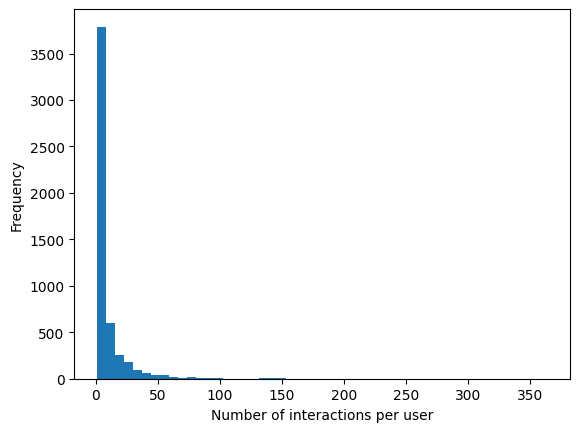

In [6]:
# Plot the distribution of interactions

plt.hist(usr_interacts.values, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Number of interactions per user")
plt.show()

We see the distribution is exponentially falling, with most users only interacting with a few articles. We re-do the same plot using a logarithmic scale to see the tail of the distribution a bit better and add some more information. We also rescale the x axis to not show the outlier at the maximum interaction value (above 350):

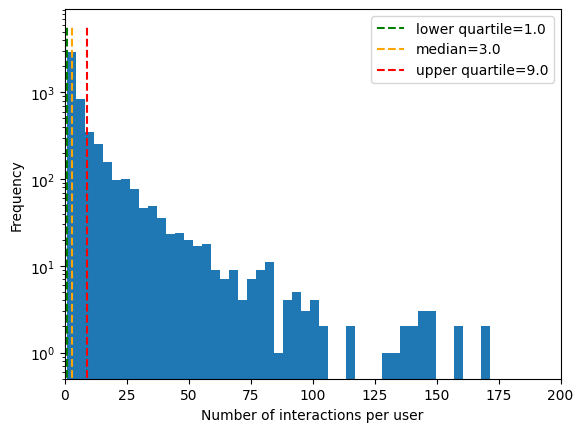

In [7]:
# Get 25% and 75% quartiles
lower_quart = np.quantile(usr_interacts.values, 0.25)
upper_quart = np.quantile(usr_interacts.values, 0.75)

# Re-do plot with added information and re-scaled axes
nhist, _, _ = plt.hist(usr_interacts.values, bins=100)
plt.plot([lower_quart, lower_quart], [0, np.max(nhist)*2], color="green",
         linestyle="dashed", label=f"lower quartile={lower_quart}")
plt.plot([median_val, median_val], [0, np.max(nhist)*2], color="orange",
         linestyle="dashed", label=f"median={median_val}")
plt.plot([upper_quart, upper_quart], [0, np.max(nhist)*2], color="red",
         linestyle="dashed", label=f"upper quartile={upper_quart}")
plt.ylabel("Frequency")
plt.xlabel("Number of interactions per user")
plt.yscale("log")
plt.ylim(5e-1, None)
plt.xlim(0,200)
plt.legend(loc="upper right")
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
num_articles = df_content["article_id"].value_counts()
print(f"Number of duplicate articles: {(num_articles.values > 1).sum()}")
print(f"Number of all articles: {df_content.shape[0]}")

Number of duplicate articles: 5
Number of all articles: 1056


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=["article_id"])

In [10]:
# Possible values for status
status_types = df_content["doc_status"].unique()
print(status_types)

['Live']


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
unique_articles = num_art_df # The number of unique articles that have at least one interaction
total_articles = num_art_dfcnt # The number of unique articles on the IBM platform
unique_users = n_usr # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

print("In our data, there exist:")
print(f"{unique_articles} unique articles that have at least one interaction.")
print(f"{total_articles} unique articles on the IBM platform.")
print(f"{unique_users} unique users.")
print(f"{user_article_interactions} user-article interactions.")

In our data, there exist:
714 unique articles that have at least one interaction.
1051 unique articles on the IBM platform.
5148 unique users.
45993 user-article interactions.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
unique_art_ids, unique_art_counts = np.unique(df["article_id"], return_counts=True)

most_viewed_article_id = f"{unique_art_ids[np.argmax(unique_art_counts)]:.1f}" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = np.max(unique_art_counts) # The most viewed article in the dataset was viewed how many times?

print(f"The most viewed article in the dataset is {most_viewed_article_id} with {max_views} views.")

The most viewed article in the dataset is 1429.0 with 937 views.


In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
# It doesn't really make sense but we need to sting-encode the article_id
# column in order to pass later assertions by udacity
df["article_id"] = df["article_id"].astype(str)

In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    unique_art_ids, unique_art_counts = np.unique(df["article_id"],
                                                  return_counts=True)
    
    if n == "max":
        n = unique_art_ids.shape[0] 
    
    top_articles = unique_art_ids[np.argsort(unique_art_counts)[::-1]][:n]

    return top_articles.tolist() # Return the top article ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids = get_top_article_ids(n, df=df)
    top_articles = df["title"][df["article_id"].isin(top_article_ids)].unique()
    
    return top_articles.tolist()

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create new column "value" that is 1 for all entries
    df_copy = df.copy()
    df_copy.loc[:, "value"] = 1
    
    user_item = df_copy.groupby(["user_id", "article_id"])["value"].max().unstack()
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def get_usr_usr_importance(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    importance - (int) the importance of the user to the user-item matrix
    
    Description:
    Computes the importance of a user to the user-item matrix
    The importance is the number of articles the user has interacted with
    '''
    
    # compute similarity of each user to the provided user
    tmp_usr = user_item.loc[user_id].values.reshape(-1, 1)
    # remove the own user's id
    other_usrs_df = user_item.drop(index=user_id)
    other_usrs = other_usrs_df.values
    importance = np.dot(other_usrs, tmp_usr).flatten()

    return importance.tolist()

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    other_usrs_df = user_item.drop(index=user_id)
    most_important = get_usr_usr_importance(user_id, user_item=user_item)

    # sort by similarity and create list of just the ids
    most_similar_users = other_usrs_df.index[np.argsort(most_important)[::-1]].to_list()

    return most_similar_users # return a list of the users in order from most to least similar


In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df["article_id"].isin(article_ids)]["title"].unique()
    
    return article_names.tolist() # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.columns[user_item.loc[user_id]==1].to_list()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find similar users
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    # Articles that the user has seen before
    usr_seen_articles, _ = get_user_articles(user_id, user_item=user_item)
    
    recs = []
    for usr in similar_users:
        if len(recs) >= m:
            recs = recs[:m]
            break
        
        # Find articles of current similar user
        similar_usr_articles, _ = get_user_articles(usr, user_item=user_item)
        
        # Articles that the similar user has seen before but the user has not
        unseen_arts = list(set(similar_usr_articles).difference(usr_seen_articles))
        recs += unseen_arts
        # remove duplicates
        recs = list(dict.fromkeys(recs))
        
    
    return recs # return your recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['data science for real-time streaming analytics',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'deep forest: towards an alternative to deep neural networks',
 'higher-order logistic regression for large datasets',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'airbnb data for analytics: mallorca reviews',
 'aspiring data scientists! start to learn statistics with these 6 books!',
 'analyze facebook data using ibm watson and watson studio',
 'from scikit-learn model to cloud with wml client']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a user has
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similar_usrs = find_similar_users(user_id)
    similarity = np.array(get_usr_usr_importance(user_id, user_item=user_item))
    similarity = similarity[np.argsort(similarity)[::-1]]
    # remove multiple occurences of the same article in one users interaction
    num_interactions = []
    for usr in similar_usrs:
        tmp_arts = df[df['user_id']==usr]['article_id'].unique().shape[0]
        num_interactions.append(tmp_arts)

    neighbors_df = pd.DataFrame({'neighbor_id': similar_usrs,
                                 'similarity': similarity,
                                 'num_interactions': num_interactions})
    
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions'],
        ascending=False
        )

    return neighbors_df

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    sorted_users = get_top_sorted_users(user_id)
    top_articles = get_top_article_ids("max")
    
    recs = []
    for usr in sorted_users["neighbor_id"]:
        
        # remove articles that the user has already seen
        tmp_recs = list(set(get_user_articles(usr)[0]).difference(set(get_user_articles(user_id)[0])))
        
        # remove articles that are already in the recommendations list
        tmp_recs = list(set(tmp_recs).difference(set(recs)))
        
        if len(recs) + len(tmp_recs) > m:
            top_indices = []
            for r in tmp_recs:
                top_indices.append(top_articles.index(r))

            tmp_recs = np.array(tmp_recs)[np.argsort(top_indices)].tolist()
            recs += tmp_recs
            recs = recs[:m]
            break

        recs += tmp_recs
        
    rec_names = get_article_names(recs)

    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'analyze energy consumption in buildings', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'finding optimal locations of new store using decision optimization', 'deep learning with tensorflow course by big data university', 'customer demographics and sales']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [28]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).loc[0]["neighbor_id"] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).loc[9]["neighbor_id"] # Find the 10th most similar user to user 131

In [29]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For new users, we are faced with the so-called "cold start problem", which describes the fact that, since no interaction records of the new user with other users or items exist, we cannot use **any** method based on collaborative filtering or user-user recommendation approaches. We therefore have to rely on **content based recommendations** entirely. The only function above that is entirely content based is the `get_top_articles` function, since it only ranks articles based on the number of unique interactions (popularity). This number is independent of the similarity of the new user with other users or items (articles) and therefore we can use it also for entirely new users.

A better way to make content-based recommendations would be to include more information about the recommended articles. For example, we could recommend not only the overall most popular articles, but also add a time criterion (e.g. the article shouldn't be older than 2 weeks, or take articles from this and last week and only then sort by popularity). We also want to recommend new users a broad range of different articles on our platform, so it would make sense to somehow get "topics" or "categories" from our articles and then make sure the recommendations include the most popular articles from each category, so the user is offered with a broader choice.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [31]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [32]:
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases

from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lamprecht/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
def general_preprocessing(tokens):
    '''
    INPUT:
    tokens - (list) a list of tokens
    
    OUTPUT:
    clean_tokens - (list) a list of cleaned tokens (removing special characters, numbers, stopwords and lemmatizing)
    
    '''
    
    # Define a regular expression pattern that matches any non-word characters
    pattern = re.compile(r'\W+')
    
    # Remove special characters from the tokens
    tokens = [pattern.sub('', token) for token in tokens]
    
    # Remove numbers, but not words that contain numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # Remove words that are only one character
    tokens = [token for token in tokens if len(token) > 1]
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        if not clean_tok in stopwords:
            clean_tokens.append(clean_tok)

    return clean_tokens

def preprocess_body_text(text):
    '''
    INPUT:
    text - (str) a string containing the body text of an article
    
    OUTPUT:
    preprocessed_text - (list) a list of clean, preprocessed tokens, being created after boilerplate removal from the text
    '''
    
    clean_text = ""
    paragraphs = justext.justext(text, justext.get_stoplist("English"))
    for paragraph in paragraphs:
        if not paragraph.is_boilerplate:
            clean_text += paragraph.text

    tokens = word_tokenize(clean_text)

    return general_preprocessing(tokens)

def preprocess_summaries(text):
    '''
    INPUT:
    text - (str) a string containing the summary/headline of an article
    
    OUTPUT:
    preprocessed_text - (list) a list of clean, preprocessed tokens
    '''

    tokens = word_tokenize(text)

    return general_preprocessing(tokens)

Check for `NaN`s

In [34]:
print(f'There are {df_content["doc_body"].isna().sum()} NaN values in the doc_body column.')
print(f'There are {df_content["doc_description"].isna().sum()} NaN values in the doc_description column.')
print(f'There are {df_content["doc_full_name"].isna().sum()} NaN values in the doc_full_name column.')

There are 14 NaN values in the doc_body column.
There are 3 NaN values in the doc_description column.
There are 0 NaN values in the doc_full_name column.


Replace `NaN`s with whitespace

In [35]:
df_content["doc_body"] = df_content["doc_body"].fillna(".")
df_content["doc_description"] = df_content["doc_description"].fillna(".")

Preprocess text: remove boilerplate for `doc_body`, tokenize, lemmatize and remove stop words and numbers

In [36]:
df_content["preprocessed_body"] = df_content["doc_body"].map(preprocess_body_text, na_action="ignore")
df_content["preprocessed_description"] = df_content["doc_description"].map(preprocess_summaries, na_action="ignore")
df_content["preprocessed_full_name"] = df_content["doc_full_name"].map(preprocess_summaries, na_action="ignore")


Create new column containing the cleaned tokens from the text body, description and full name

In [37]:
df_content["preprocessed_content"] = df_content["preprocessed_body"] + df_content["preprocessed_description"] + df_content["preprocessed_full_name"]

Compute bigrams and add them to the tokens. This will help us to get common combinations of words such as "machine_learning" or "real_time" in our corpus

In [38]:
# Add only bigrams that appear 20 times or more.
bigram = Phrases(df_content["preprocessed_content"], min_count=20)
for i, doc in enumerate(df_content["preprocessed_content"]):
    for token in bigram[doc]:
        if '_' in token:
            # Token is a bigram, add to document.
            doc.append(token)

Create corpus from preprocessed content of articles:

In [39]:
dictionary = corpora.Dictionary(df_content["preprocessed_content"])

# Next, we filter out words that either occur in less
# than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in df_content["preprocessed_content"]]

Transform into TF-IDF matrix:

In [40]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_content["preprocessed_content"].apply(lambda x: " ".join(x)))

The idea here is to come up with a recommendation for new users based on a blend of two approaches:

1.) Use Latent Dirichlet Allocation (LDA) to discover topics in the article text, then recommend top articles from a range of different topics

2.) Using a large language model (GPT-3) to find topics/keywords for each article and then do recommendations based on the most popular keywords

Let's start with the first step

## 1. Using LDA to figure out topics in the article text

First, we find out the optimal number of topics using `gensim`'s coherence model. We start from two topics and scan up to eleven possible topics. We look for the maximum coherence score and then take the LDA model based on the number of topics that achieves that score.

The maximum coherence score is a good measure of the optimal number of topics because it indicates the level of interpretability and coherence of the topics produced by the LDA model. A higher coherence score means that the topics are more distinct and coherent, with words that are highly associated with each other within a topic and less associated with words in other topics. This makes the topics more useful for our recommendation engine.

In [41]:
# we use c_npmi coherence score here, which can range from -inf to 1, so we
# set the initial coherence to the lowest possible value
current_coherence = -np.inf
for n_topics in range(2, 11):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics,
                         alpha='auto', eta='auto',
                         chunksize=200, passes=20, iterations=400,
                         random_state=42, eval_every=None)

    coherence_model = CoherenceModel(model=lda_model, texts=df_content["preprocessed_content"],
                                     dictionary=dictionary, coherence='c_npmi')

    if coherence_model.get_coherence() > current_coherence:
        current_coherence = coherence_model.get_coherence()
        best_lda_model = lda_model
        best_n_topics = n_topics


print("The optimal number of topics is {}.".format(best_n_topics))

The optimal number of topics is 7.


We found that the optimal number of topics is 7. Note that we fixed the random state of our LDA model in this case, which means we didn't take into account any variance of our result due to the random initialization of our model. For this showcase of LDA we are more interested in getting reproducible results, so fixing the seed is fine for now.

Next, let's take a look at our topics:

In [42]:
best_lda_model.print_topics()

[(0,
  '0.016*"database" + 0.013*"cloudant" + 0.012*"application" + 0.011*"function" + 0.009*"app" + 0.009*"document" + 0.008*"web" + 0.008*"user" + 0.007*"file" + 0.007*"name"'),
 (1,
  '0.045*"model" + 0.043*"learning" + 0.032*"machine" + 0.026*"machine_learning" + 0.019*"algorithm" + 0.013*"training" + 0.010*"set" + 0.009*"regression" + 0.009*"feature" + 0.009*"variable"'),
 (2,
  '0.046*"science" + 0.037*"data_science" + 0.021*"email" + 0.014*"week" + 0.013*"course" + 0.011*"november" + 0.011*"june" + 0.011*"new" + 0.011*"blog" + 0.011*"big"'),
 (3,
  '0.010*"one" + 0.009*"like" + 0.009*"time" + 0.009*"value" + 0.007*"ha" + 0.007*"wa" + 0.007*"example" + 0.007*"process" + 0.006*"need" + 0.005*"python"'),
 (4,
  '0.022*"ibm" + 0.018*"analytics" + 0.017*"blog" + 0.013*"user" + 0.012*"business" + 0.010*"big" + 0.009*"source" + 0.009*"system" + 0.008*"scientist" + 0.008*"data_scientist"'),
 (5,
  '0.025*"click" + 0.019*"new" + 0.018*"spark" + 0.014*"email" + 0.012*"ibm" + 0.012*"window

We see our seven topics here, as well as the words with the highest significance per topic. We can clearly see that there are differences in the different topics, however, the overlap is still large. Fore example, the bigrams `data_science` and `data_scientist` occur in different topics, so does the word `ibm` etc. Of course, since these articles are from an IBM platform, we expect all of these articles to be in the "tech" realm, so we will probably always have *some* overlap. Nevertheless, one could play around with the hyperparamters even more or for example extend the bag-of-words model to also include trigrams.

For now, lets go on with this study and assign a topic to each of our articles:

In [43]:
# Get topic distribution for each document in the corpus
topic_distribution = []
for doc in corpus:
    doc_topics = best_lda_model.get_document_topics(doc)
    topic_distribution.append(doc_topics)

In [44]:
# Use topic probabilities to assign a topic to each document
topic_assignments = []
for doc_topics in topic_distribution:
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    top_topic = sorted_topics[0][0]
    topic_assignments.append(top_topic)

In [45]:
# Add topic assignments to the dataframe
df_content["topic"] = topic_assignments

Let's take a look at the topic distribution in our dataset:

In [46]:
df_content["topic"].value_counts()

topic
0    324
3    166
5    141
6    137
4    118
2     91
1     74
Name: count, dtype: int64

We can see that none of the topics occurs very rarely. The lowest count is 74 and all the other topics have occurrences in a similar ball park, say, around 150 times. The first topic (index `0`) occurs most frequently, with 324 documents.

One difficulty is to interpret the topics here and assign them fitting names or keywords. We could just take the most significant words for each topic, as discussed above, but due to the large overlap between the topics, this will be hard and anyway it is difficult to make sense of them.

Nevertheless, we can try to make some observations: We can see that some of the topics are blog posts about specific software. For example, the first topic seems to contain many articles about `cloudant`, which is a NoSQL database service by IBM. One of the most significant words in topic 5 is `spark`, which probably refers to Apache Spark, which is a distributed computing system designed for processing large-scale datasets.

The most significant words of the second topic seem to be all about machine learning jargon, so these are probably blog posts about machine learning. The third topic contains both many words referring to time (week, november, june) as well as data science. When skimming through the dataset, I saw something like "data science weekly" and I guess most documents from this topic originate there. It's also a newsletter, so "email" being amongst the most significant words makes sense as well.

Topic five has "ibm" "analytics" and "blog" as most significant words. Looking at other significant words, these seem to be blogs about data science for business analytics. Topic seven has "watson" and "ibm" as its most significant words, so these are probably blog posts writing about IBM Watson, which is a suite of AI / ML tools and technologies developed by IBM. The most difficult topic to assess is the fourth topic. I was filtering those out and printing some examples of the `"doc_body"` column to make sense of them (not included in notebook, but feel free to do the exercise yourself), but I found these are from a variety of sources. Some are from the Kaggle blog "no free hunch" others are medium blog posts etc. Maybe the more general category "tech blog" would fit here for now.

Let's assign some labels for the topic assignments for now and then continue:

In [47]:
# Create new column for each topic and assign 1 if the article belongs to that topic:
df_content = pd.concat([df_content, pd.get_dummies(df_content["topic"], prefix="Topic")], axis=1)

# Rename the columns to make them more readable
df_content.rename(columns={"Topic_0": "Topic Cloudant/Databases",
                           "Topic_1": "Topic Machine Learning",
                           "Topic_2": "Topic Data Science/Newsletters",
                           "Topic_3": "Topic Tech Blog",
                           "Topic_4": "Topic IBM business analytics",
                           "Topic_5": "Topic Apache Spark",
                           "Topic_6": "Topic IBM Watson"}, inplace=True)

## 2.) Use Large Language Model (LLM) to get five keywords describing each of the articles

**NOTE:** For this part you'll need your own openAI API key and set it as an environment variable **OR** you simply load the results that I acquired myself using my own API key. See the comments in the below code cells for more details

In [48]:
def get_cropped_prompt(doc, gpt_tokenizer):
    '''
    INPUT:
    doc - (str) a string containing the body, description and title of an article
    gp_tokenizer - (GPT2/3 tokenizer) the tokenizer used to tokenize the prompt
    
    OUTPUT:
    doc - The same as input doc, but cropped to 4096 tokens (required limit for GPT3)
    tmp_num_tokens - The number of tokens in the cropped doc
    '''
    
    # get initial number of tokens
    prompt = ("Here is a web article/blog post, give me 5 keywords, each keyword on a new line, that describe what the article is about"
              f"\n\n --- Beginning of article ---- \n\n  {doc} \n\n  --- End of article ---:")
    tmp_num_tokens = len(gpt_tokenizer(prompt)['input_ids'])
    
    # Check if number of tokens is too large and crop away 100 strings until lower number is reached
    while(tmp_num_tokens > 4096):
        doc = doc[:len(doc)-100]
        prompt = ("Here is a web article/blog post, give me 5 keywords, each keyword on a new line, that describe what the article is about"
                  f"\n\n --- Beginning of article ---- \n\n  {doc} \n\n  --- End of article ---:")
        tmp_num_tokens = len(gpt_tokenizer(prompt)['input_ids'])
    
    return doc, tmp_num_tokens

In [49]:
# Before we use LLM, let's get an idea of how many tokens we need:
num_tokens_full = 0
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
for doc in df_content["preprocessed_content"]:
    tmp_doc, tmp_num_tokens = get_cropped_prompt(doc, gpt_tokenizer)
    num_tokens_full += tmp_num_tokens

print(f"Total number of tokens: {num_tokens_full}")

Token indices sequence length is longer than the specified maximum sequence length for this model (6697 > 1024). Running this sequence through the model will result in indexing errors


Total number of tokens: 1518784


In [50]:
# Let's also get an idea of how much this will cost us:
# At the time of writing, the cost per 1k tokens of gpt-3.5-turbo is 0.002 USD
costs_gpt3 = 0.002
costs_prompt = (num_tokens_full/1000)*costs_gpt3

# Assuming we use 100 output tokens per doc, which is probably way too high (since we're instructing GPT3 to output just 5 keywords)
# But let's just use this as a worst case scenario
max_costs_output = ((df_content["preprocessed_content"].shape[0]*100)/1000)*costs_gpt3
max_costs_tot = costs_prompt + max_costs_output
print(f"Maximum costs for all tokens using gpt-3.5-turbo model: {max_costs_tot:.2f} USD")

Maximum costs for all tokens using gpt-3.5-turbo model: 3.25 USD


In [51]:
# Set whether you want to run the GPT model or whether to load pre-computed results
#
# By default, we load the pre-computed results (I pre-computed the results using my personal GPT3 API key)
# but feel free to change this to True if you want to run it yourself (and pay the 3 bucks ;) ). Note that
# the OPENAI_API_KEY environment variable needs to be set for this to work.
use_gpt = False

In [52]:
if use_gpt:
    import openai
    openai.api_key = os.getenv("OPENAI_API_KEY")

    keywords = {}

    for i, doc in enumerate(df_content["preprocessed_content"]):
        if i in keywords.keys():
            continue
        
        tmp_doc, _ = get_cropped_prompt(doc)
        prompt = ("Here is a web article/blog post, give me 5 keywords, each keyword on a new line, that describe what the article is about"
                    f"\n\n --- Beginning of article ---- \n\n  {tmp_doc} \n\n  --- End of article ---:")
        
        response_gpt3 = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt}
                ]
            )
        
        keywords[i] = response_gpt3["choices"][0]["message"]["content"].splitlines()
    
    # save as json file
    with open("gpt3_keywords.json", "w") as f:
        json.dump(keywords, f, indent=4)
else:
    with open("keywords_cleaned.json", "r") as f:
        keywords = json.load(f)

In [53]:
# Add keywords to dataframe
df_content["keywords"] = keywords.values()

In [54]:
# Find the most common keywords
keyword_counts = {}
for i, doc in enumerate(keywords.values()):
    for keyword in doc:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1

# Save top 20 most frequent keywords as a list of key/value tuples
top_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:20]

In [55]:
top_keywords

[('data science', 155),
 ('machine learning', 107),
 ('cloudant', 91),
 ('ibm', 76),
 ('database', 75),
 ('data', 73),
 ('video', 56),
 ('big data', 55),
 ('python', 53),
 ('compose', 47),
 ('postgresql', 41),
 ('apache spark', 35),
 ('ibm watson', 34),
 ('mongodb', 32),
 ('cloud', 25),
 ('data analysis', 23),
 ('data visualization', 23),
 ('bluemix', 23),
 ('open source', 22),
 ('deep learning', 22)]

We see that the same problem occurs with GPT-3 as with the LDA model: We have several keyword "categories", but many of them overlap. For example, "data science" is the category with the most articles. Since many articles are written about it, we assume it is a "popular" topic (even though we don't have any actual user-popularity data to prove this claim). However, many other frequently occurring keywords are closely related to data science. For example, machine learning methods are often considered an integral part of data science and yet "machine learning" is the second most frequent keyword. We also see the sixth most important keyword is just "data", which overlaps with almost all other keywords in the list at least somewhat.

Thus, in order to get good content-based recommendations, we need to have some domain-knowledge about the specific set of articles we are trying to recommend. In a tech environment like this, it is almost inevitable to have some overlap between topics/keywords. The question is how to separate the keywords into topics such that it makes sense to the assumed audience of our platform.

Therefore, we will still need to come up with some categories using the GPT-3 generated keywords. This is what I came up with:

- "data science" seems like a broader, more general category, which is why - apart from the "data science" keyword itself - I included some of the more general terms here: "data", "big data" and "cloud". I also thought about including "data analysis" and "data visualization" here - both are obvious parts of data science - but in the end decided against it, since they seem more specific, technical terms.
- I think the "machine learning" category is geared more towards technically skilled users who want to know about the latest and greatest ML algorithms. Thus, I included also the "deep learning" keyword here.
- "cloudant" was the most difficult category to form: Cloudant is clearly an IBM service, so it would fit extremely well in an "IBM Services" category. On the other hand, it is specifically a **database** service. And as we can see from the list of keywords, there are many database-related keywords here. So we can assume that there are many users interested in this particular field. Therefore, I decided to do a separate "Database tools" category, containing keywords "cloudant", "database", "postgresql" and "mongodb".
- I still kept the fourth "IBM Services" category, including "ibm", "ibm watson" and "bluemix" keywords.
- Finally I just used "video" as the final category.

Another drawback of the GPT-based approach compared to LDA is that we don't get *probabilities* of the different keywords/categories, so we can't assign documents to a specific category as easily as with LDA. Therefore, a single article/blog post can be in multiple categories at the same time. I will create one column for each of the "top five" categories described above in the `df_content` dataframe and just one-hot encode whether the article is in each of the categories (based on the described keyword assignment) or not:

In [56]:
# create lists containing keywords for category assignment
cat_data_science = ["data science", "data", "big data", "cloud"]
cat_ml = ["machine learning", "deep learning"]
cat_db_tools = ["cloudant", "database", "postgresql", "mongodb"]
cat_ibm_services = ["ibm", "ibm watson", "bluemix"]
cat_video = ["video"]

In [57]:
# One-hot encode the categories, put "Keyword" identifier in front of the column name
# to signify that this is a category from the GPT3 keywords
df_content["Keyword Data Science"] = 0
df_content["Keyword Data Science"] = df_content["keywords"].apply(lambda x: 1 if any([keyword in cat_data_science for keyword in x]) else 0)
df_content["Keyword Machine Learning"] = 0
df_content["Keyword Machine Learning"] = df_content["keywords"].apply(lambda x: 1 if any([keyword in cat_ml for keyword in x]) else 0)
df_content["Keyword Database Tools"] = 0
df_content["Keyword Database Tools"] = df_content["keywords"].apply(lambda x: 1 if any([keyword in cat_db_tools for keyword in x]) else 0)
df_content["Keyword IBM Services"] = 0
df_content["Keyword IBM Services"] = df_content["keywords"].apply(lambda x: 1 if any([keyword in cat_ibm_services for keyword in x]) else 0)
df_content["Keyword Video"] = 0
df_content["Keyword Video"] = df_content["keywords"].apply(lambda x: 1 if any([keyword in cat_video for keyword in x]) else 0)

In [58]:
def get_similar_articles(df_content, viewed_ids):
    '''
    INPUT:
    df_content - dataframe containing article content as well as category assignments
    viewed_ids - list of article ids that the user has already viewed
    
    OUTPUT:
    similar_ids - list of article ids that are similar to the articles the user has already viewed
    '''
    categories = [col for col in df_content.columns if (("Keyword" in col) or ("Topic" in col))]
    viewed_df = df_content[df_content["article_id"].isin(viewed_ids)][categories]
    other_df = df_content[~df_content["article_id"].isin(viewed_ids)][categories]
    other_ids = df_content[~df_content["article_id"].isin(viewed_ids)]["article_id"]
    similarities = np.dot(viewed_df.values, other_df.values.T).sum(axis=0)
    similar_ids = other_ids.iloc[np.argsort(similarities)[::-1]].values
    return similar_ids

def get_category_popularity(df_content=df_content, df=df):
    '''
    INPUT:
    df_content - dataframe containing article content as well as category assignments
    
    OUTPUT:
    popularity - dictionary containing the average popularity of each category
    '''
    
    # We need the next line to get around the issues of the article id being
    # string-encoded in the original df
    tmp_ids = df["article_id"].astype(str).str[:-2].astype(int)
    categories = [col for col in df_content.columns if (("Keyword" in col) or ("Topic" in col))]
    popularities = {}
    for cat in categories:

        _, counts = np.unique(
            df["article_id"][tmp_ids.isin(df_content[df_content[cat]==1]["article_id"])],
            return_counts=True
            )

        # Assign score to category
        popularities[cat] = np.mean(counts)
    
    return popularities

def get_top_articles_from_category(df_content):
    '''
    INPUT:
    df_content - dataframe containing article content as well as category assignments
    
    OUTPUT:
    cat_popular_articles - dictionary containing the most popular article IDs for each category
    '''
    
    # List of article IDs in decending order of popularity
    popular_articles = get_top_article_ids("max")
    popular_articles = [int(article[:-2]) for article in popular_articles]
    not_viewed = np.setdiff1d(df_content["article_id"].values,
                              popular_articles,
                              assume_unique=True).tolist()
    popular_articles = popular_articles + not_viewed
    
    # List of categories
    categories = [col for col in df_content.columns if (("Keyword" in col) or ("Topic" in col))]
    
    # Get dictionary where the keys are the category names and the values are lists of article
    # IDs, sorted by popularity in descending order
    cat_popular_articles = {}
    for cat in categories:
        tmp_articles = df_content[df_content[cat]==1]["article_id"].values
        cat_popular_articles[cat] = [article for article in popular_articles if article in tmp_articles]
    
    return cat_popular_articles

def make_content_recs(df_content, viewed_articles=None, num_recs=10):
    '''
    INPUT:
    df_content - dataframe containing article content as well as category assignments
    viewed_articles - list of article ids that the user has already viewed
    num_recs - number of recommendations to return
    
    
    OUTPUT:
    recs - list of recommended article ids
    '''
    
    # get most popular articles by category
    cat_popular_articles = get_top_articles_from_category(df_content)
    
    if viewed_articles is None:
        # If no articles have been viewed yet, return most popular articles from each category,
        # in descending order of topic/keyword category popularity
        popularities = get_category_popularity(df_content)
        sorted_categories = sorted(popularities.items(), key=lambda x: x[1], reverse=True)
        sorted_categories = [cat[0] for cat in sorted_categories]
        recs = []
        while len(recs) < num_recs:
            tmp_len = len(recs)
            tmp_cat = sorted_categories[tmp_len % len(sorted_categories)]
            for artcl in cat_popular_articles[tmp_cat]:
                if artcl not in recs:
                    recs.append(artcl)
                    break
            
            # Check if an article was actually added. This is to catch the
            # case when all articles from a category have already been added
            # which would otherwise result in an infinite loop. If this
            # happens, remove the affected category from the list of most
            # popular categories.
            if tmp_len == len(recs):
                sorted_categories.pop(tmp_len % len(sorted_categories))

    elif (len(viewed_articles) > 0) & (len(viewed_articles) <= 10):
        # If the user hase viewed some articles, we base our recommendations on both article similarity
        # and strictly content based techniques. We first get the most similar articles according to
        # topic/keyword categories and then we add the most popular articles from each category as usual.
        recs = []
        
        # Get most popular articles by category first:
        content_recs, _ = make_content_recs(df_content, viewed_articles=None, num_recs=num_recs//2)
        
        # Get most similar articles compared to already viewed articles:
        similarity_recs = get_similar_articles(df_content, viewed_articles)
        
        recs = recs + content_recs
        for rec in similarity_recs:
            if rec not in recs:
                recs.append(rec)
            if len(recs) == num_recs:
                break
    else:
        # If the user has viewed more than 10 articles, we recommend to use user-user similarity instead
        # Since this is a different technique, we throw an error here.
        raise ValueError(("The user has viewed more than 10 articles and "
                          "therefore we recommend to use user-user "
                          "recommendations instead of content-based "
                          "recommendations here."))

    rec_names = get_article_names(recs)

    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

Much of this has been discussed earlier, but here is a short description of what's happening with the entirely content-based recommender:

My idea was to categorize the articles into topics and then recommend articles across various topics to get a broader coverage of recommended articles compared to a purely popularity-based approach. To get the topics, I specifically used two different approaches:

1.) Using natural language processing (NLP) tools, in particular latent dirichlet allocation (LDA) to categorize the corpus of articles into topics.
2.) Using a large language model (LLM), in particular GPT-3, to get five keywords describing each article, then categorizing based on sets of similar keywords that have a high frequency.

Overall, we get 7 categories from approach 1.) and decided to come up with 5 categories from approach 2.). 

Depending on how many articles the user has already seen, we then use different recommendation approaches:

- if the user has not read any articles (entirely new user), we recommend articles from all of the categories, moving through categories in descending order of average article popularity per category
- if the user has read *some* articles (in particular, between 1 and 10), we use a hybrid approach: the returned recommendations will be a mixture of the first approach to still allow for serendipitous discoveries and an approach based on article similarity. Article similarity is computed as the dot product of the article-category matrices of already viewed articles with non-viewed articles. For the LDA approach, we could just have recommended articles from the same category, as each article belongs to one category exclusively in our implementation. However, for the LLM approach, one article could be assigned to several categories at the same time, so the dot-product similarity makes sense to compute.
- if the user has read many articles (more than 10), we can't really talk of an entirely new user here and we thus recommend user-user similarity or collaborative filtering techniques here, since they usually outperform purely content-based approaches.

Using LLMs to categorize a corpus of articles is a great way of using this new technology! Of course, one could extend the categorization method further and do all sorts of advanced techniques with this information. For example, we could build a huge matrix of all articles vs all keywords and apply a clustering algorithm (like k-means clustering) to figure out categories based on keyword similarity.

When computing the article similarity, we could also take a matrix that contains the actual LDA probabilites for each category (instead of forcing each article in one category exclusively), to get a better estimate of how similar two articles are to each other.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [59]:
# make recommendations for a brand new user
rec_ids, rec_names = make_content_recs(df_content)

# make a recommendations for a user who only has interacted with article id '1427.0'
rec_ids_viewed, rec_names_viewed = make_content_recs(df_content, viewed_articles=["1427.0"])


In [60]:
print(rec_ids)

[260, 730, 151, 43, 164, 124, 732, 241, 120, 390]


In [61]:
print(rec_ids_viewed)

[260, 730, 151, 43, 164, 1050, 360, 358, 357, 356]


We see that, when the user is entirely new to our platform, we only get the standard content-based recommendations, while as soon as the user has viewed one article, the first half of the recommendations is still based on content entirely, while the second half consists of popular articles from similar categories.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [62]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [63]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [64]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

The main difference between the article recommendation engine in this notebook and the movie recommendations in the lesson is that there are no ratings involved for the articles on the IBM watson platform. Therefore, the user-item-matrix only contains information about whether a user interacted with an article or not and we can use the value `0` to indicate "no interaction" and `1` to indicate "interaction".

For the movie recommendations in the lesson, this was different: the values in the user-item matrix were **ratings** ranging from values 1 (poor rating) to 10 (good rating). Filling in the value `0` in places where user-item interactions are missing (i.e. the respective user hadn't seen/rated the movie in question) would cause our method to think that this user rated this movie very poorly (below the actual lowest rating value of `1`). **In the movie rating scheme, the number `0` has an actual meaning** which is not true for the case with the IBM watson articles, where we just encode the binary information "interaction"/"no interaction" with the values `1`/`0`.

Therefore, in the movie rating scheme, we need to keep the missing **`NaN`** values and use "FunkSVD" which can handle sparse matrices that contain a lot of `NaN`s. For the IBM watson article case, we can use the "default" SVD of `numpy`, because we can encode the missing user-item interactions with the `0` value and thus the user-item matrix doesn't contain any `NaN` values that would cause the algorithm to break.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

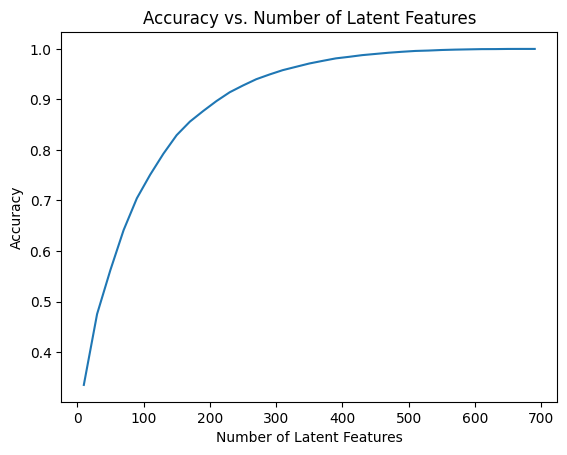

In [65]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [66]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test["user_id"].unique()
    test_arts = df_test["article_id"].unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [67]:
# users in the test set that are not in the train set
test_not_in_train = np.setdiff1d(test_idx, df_train["user_id"].unique()).shape[0]

# users in the test set that are also in the train set
test_in_train = np.intersect1d(test_idx, df_train["user_id"].unique()).shape[0]

# articles in the test set that are not in the train set
arts_not_in_train = np.setdiff1d(test_arts, df_train["article_id"].unique()).shape[0]

# articles in the test set that are also in the train set
arts_in_train = np.intersect1d(test_arts, df_train["article_id"].unique()).shape[0]

print(f"We can make predictions for {test_in_train} users in the test set.")
print(f"We cannot make predictions for {test_not_in_train} users in the test set because of the cold start problem.")
print(f"We can make predictions for {arts_in_train} articles in the test set.")
print(f"We cannot make predictions for {arts_not_in_train} articles in the test set because of the cold start problem.")

We can make predictions for 20 users in the test set.
We cannot make predictions for 662 users in the test set because of the cold start problem.
We can make predictions for 574 articles in the test set.
We cannot make predictions for 0 articles in the test set because of the cold start problem.


In [68]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [69]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [70]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
common_usr_indices = np.intersect1d(test_idx, df_train["user_id"].unique())
common_arts_indices = np.intersect1d(test_arts, df_train["article_id"].unique())
common_usr_item_test = user_item_test.loc[common_usr_indices, common_arts_indices]


In [71]:
# find indices of user_ids and article_ids in the train set
user_matches = np.where(user_item_train.index.isin(common_usr_indices))[0]
arts_matches = np.where(user_item_train.columns.isin(common_arts_indices))[0]

# set matrices to only include users and articles common to both train and test set
u_mat_common = u_train[user_matches, :]
vt_mat_common = vt_train[:, arts_matches]

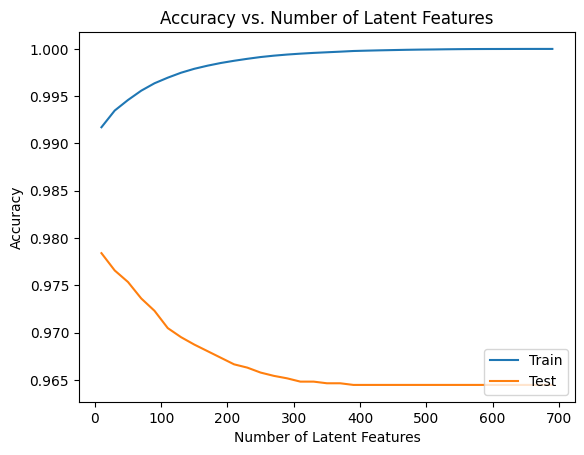

In [72]:
# run same loop as above, but now comparing training and test performance
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    s_new_test, u_new_test, vt_new_test = np.diag(s_train[:k]), u_mat_common[:, :k], vt_mat_common[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_test), vt_new_test))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(common_usr_item_test, user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(common_usr_item_test.shape[0]*common_usr_item_test.shape[1]), label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

We can clearly see that the SVD is overfitting on the training set. The more we increase the number of latent features, the better the performance will be on the training set. However, we are optimizing our algorithm to fit exactly this set of data. Once we apply the algorithm to a different, statistically independent dataset, the performance is getting worse, because the algorithm is so overfit on the training set that it doesn't generalize well to new data points. Therefore, we should stick to a small number of latent features, which guarantees the lowest amount of overfitting and thus the best generalization performance of the matrix factorization algorithm.

The second part of the question is what we might do to determine if our recommendations work better than the current implementation. One way is to do what we already did: Split our data into a training and test set, optimize our recommendation engine on the training set and then apply to the test set. We can then compare the test performance of our new recommender to that of the current implementation and see if it is better. The tricky part here is how to do the split: Since we might want to use collaborative filtering, we cannot split based on user ID, because users in the test and training sets would then be different and we thus couldn't apply our algorithm that was tuned on the training set to the test set. However, we can make a split in time: restrict the training set to user-item interactions from an earlier time (for example last year) and then try to predict more recent user-item interactions as a test set (for example interactions from the current year).

A second method would be to conduct an A/B test using a different recommendation method for the experiment group and keep the current implementation for the control group. We can then look if an improvement for example on the incremental response can be observed for the new recommendation engine. This approach is very risky, however, since deploying an experiment to real users without prior testing and validation is usually not recommendable. After all, we might loose valuable customers from the experiment group if the new recommendation engine does a very poor job. 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [73]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb', '--to', 'html'])

/home/lamprecht/code/ibm_recommendation_engine/ibm_rec_env_test/bin/python: No module named nbconvert


1